In [5]:
import torch
import norse
from norse.torch.functional.lif_adex import LIFAdExParameters
import norse.torch as snn
import torch.nn as nn
from cgtask.tasks.tasks import MultyTask
from tqdm import tqdm
from tasks import ContextDM, CompareObjects, WorkingMemory, MultyTask
from exponent_filter import ExpFilter
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')
print(f'Device: {("gpu (cuda)" if device.type=="cuda" else "cpu")}')

# print(neuron_parameters)
class SNNMULTYTASK(torch.nn.Module):
    def __init__(
        self, feature_size, hidden_size, output_size, neuron_parameters
    ) -> None:
        super(SNNMULTYTASK, self).__init__()
        # self.poisson = snn.PoissonEncoder(100)
        # self.lif0 = snn.LIFRecurrent(feature_size, hidden_size)
        self.alif = snn.LIFAdExRecurrent(feature_size, hidden_size, p=neuron_parameters)
        # self.lif = snn.LIFRecurrent(feature_size, hidden_size)
        self.exp_f = ExpFilter(hidden_size, output_size, 0.8)
        # self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # out, state = self.lif0(x)
        out, state = self.alif(x)
        # out = self.linear(out)
        out = self.exp_f(out)
        return (out, state)

ModuleNotFoundError: No module named 'cgtask'

In [8]:
import cgtask

ModuleNotFoundError: No module named 'cgtask'

In [2]:
import numpy as np

# 0. Create dataset


batch_size = 20
task_list = [("WorkingMemory", dict()), (("ContextDM", dict()))]
tasks = dict(task_list)
CDM_task = MultyTask(tasks, batch_size=batch_size)
# inputs, labels, ob_size, act_size = CDM_task.dataset()


feature_size, output_size = CDM_task.feature_and_act_size[0]
hidden_size = 400

# 1. model


neuron_parameters = LIFAdExParameters(
    tau_ada_inv=torch.Tensor([2]).to(device), alpha=100
)
model = SNNMULTYTASK(feature_size, hidden_size, output_size, neuron_parameters).to(
    device
)
with torch.no_grad():
    weights_pre_l = []
    for name, param in model.named_parameters():
        if param.requires_grad:
            weights_pre_l.append((param).cpu().numpy())
            # print (name, param.data)

# 2. loss and optimizer
learning_rate = 5e-2


class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y))


criterion = nn.MSELoss()
criterion_test = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.8, 0.85))
running_loss = 0.0

In [21]:
# 3. train loop
%matplotlib
# fig, ax = plt.subplots()
plt.ion()
fig = plt.figure()
ax = fig.add_subplot(111)
inputs, target_outputs = CDM_task.dataset(10)
(line1,) = ax.plot(np.arange(0, len(target_outputs)), target_outputs[:, 0, 1], "b-")
(line2,) = ax.plot(np.arange(0, len(target_outputs)), target_outputs[:, 0, 2], "r-")
(line3,) = ax.plot(np.arange(0, len(target_outputs)), target_outputs[:, 0, 1], "b-")
(line4,) = ax.plot(np.arange(0, len(target_outputs)), target_outputs[:, 0, 2], "r-")
ax.set_ylim([-0.5, 1.5])
ax.set_xlim([0, 20000])
for i in range(500):
    inputs, target_outputs = CDM_task.dataset(10)
    inputs += np.random.normal(0, 0.01, size=(inputs.shape))
    inputs = torch.from_numpy(inputs).type(torch.float).to(device)
    target_outputs = torch.from_numpy(target_outputs).type(torch.float).to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs, states = model(inputs)

    loss = criterion(outputs, target_outputs)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i % 10 == 9:
        print("epoch: {:d} loss: {:0.5f}".format(i + 1, running_loss / 10))
        running_loss = 0.0
        with torch.no_grad():
            inputs, target_outputs = CDM_task.dataset(10)

            inputs = torch.from_numpy(inputs).type(torch.float).to(device)
            target_outputs = (
                torch.from_numpy(target_outputs).type(torch.float).to(device)
            )
            outputs, states = model(inputs)
            loss = criterion_test(outputs, target_outputs)

            print("test loss: {:0.5f}".format(loss.item()))
        for_plot = outputs.detach().cpu().numpy()[:, 0, :]
        line1.set_xdata(np.arange(0, len(for_plot), 1))
        line2.set_xdata(np.arange(0, len(for_plot), 1))
        line3.set_xdata(np.arange(0, len(for_plot), 1))
        line4.set_xdata(np.arange(0, len(for_plot), 1))
        line1.set_ydata(for_plot[:, 1])

        # line1.set_xdata(np.arange(0, len(for_plot)))
        line2.set_ydata(for_plot[:, 2])
        line3.set_ydata(target_outputs.detach().cpu().numpy()[:, 0, 1])
        line4.set_ydata(target_outputs.detach().cpu().numpy()[:, 0, 2])
        # line2.set_xdata(np.arange(0, len(for_plot)))
    fig.canvas.draw()
    fig.canvas.flush_events()


print("Finished Training")

Using matplotlib backend: TkAgg
epoch: 10 loss: 0.01436
test loss: 0.02312
epoch: 20 loss: 0.01452
test loss: 0.03002
epoch: 30 loss: 0.01206
test loss: 0.00911
epoch: 40 loss: 0.01766
test loss: 0.02255
epoch: 50 loss: 0.01568
test loss: 0.00698
epoch: 60 loss: 0.02126
test loss: 0.03355
epoch: 70 loss: 0.01219
test loss: 0.00460
epoch: 80 loss: 0.01710
test loss: 0.01411
epoch: 90 loss: 0.01132
test loss: 0.04146
epoch: 100 loss: 0.01267
test loss: 0.00507
epoch: 110 loss: 0.01660
test loss: 0.00481
epoch: 120 loss: 0.01372
test loss: 0.02780
epoch: 130 loss: 0.01674
test loss: 0.00820
epoch: 140 loss: 0.01933
test loss: 0.00618


KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots()
for i in range(100):
    x = np.arange(100)
    y = np.full([100], fill_value=i)
    plot_something_live(ax, y)

inputs.shape = (30389, 1, 8)
outputs.shape = (30389, 1, 5)


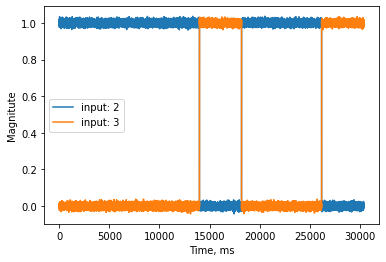

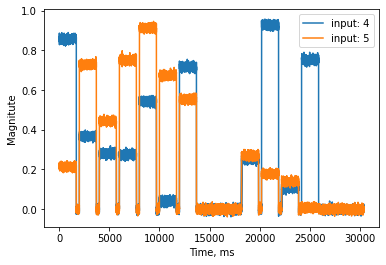

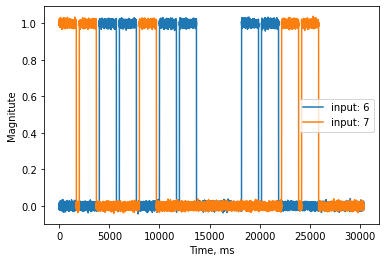

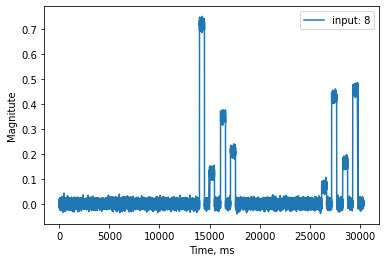

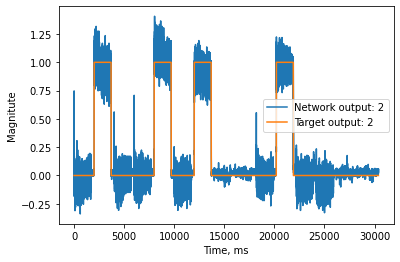

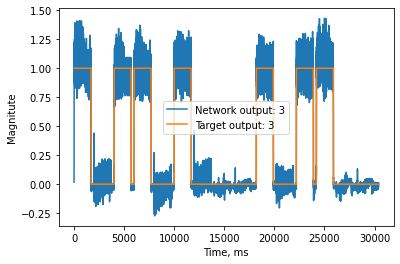

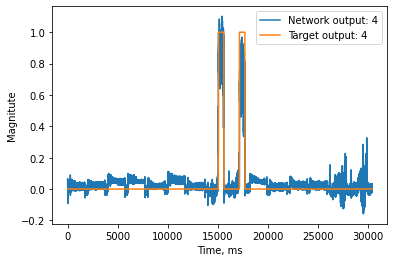

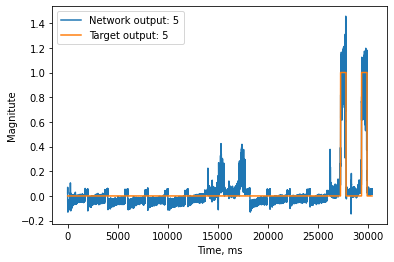

In [38]:

# 0. Create dataset
%matplotlib inline
dt = 1e-3

batch_size = 1
CDM_task = MultyTask(tasks=tasks, batch_size=batch_size)
inputs, labels = CDM_task.dataset(15)
inputs += np.random.normal(0, .01, size=(inputs.shape))

inputs = torch.from_numpy(inputs).type(torch.float).to(device)  
feature_size, output_size = CDM_task.feature_and_act_size

# 1. model

if False:
    
    model = SNNMULTYTASK(feature_size, hidden_size, output_size).to(device)
    with torch.no_grad():
        for name, param in model.named_parameters(): 
            param.copy_(torch.from_numpy( np.load(f'./data/{name}.npy')).to(device))
#labels = torch.from_numpy(labels.flatten()).type(torch.long).to(device)
with torch.no_grad():
    outputs, state = model(inputs)
    inputs = inputs.cpu().numpy() 
    outputs = outputs.cpu().numpy()
    print(f'inputs.shape = {inputs.shape}')
    print(f'outputs.shape = {outputs.shape}')
    for i in range(1, inputs.shape[2] - 1, 2):
        plt.plot(inputs[:, 0, i], label=f'input: {i + 1}')
        plt.plot(inputs[:, 0, i + 1], label=f'input: {i + 2}')
        plt.legend()
        plt.xlabel('Time, ms')
        plt.ylabel('Magnitute')
        plt.show()
        plt.close()
    plt.plot(inputs[:, 0, -1], label=f'input: {inputs.shape[2]}')
    plt.legend()
    plt.xlabel('Time, ms')
    plt.ylabel('Magnitute')
    plt.show()
    plt.close()
    
    for i in range(1, target_outputs.shape[2]):
        plt.plot(outputs[:, 0, i], label=f'Network output: {i + 1}')
        plt.plot(labels[:, 0, i], label=f'Target output: {i + 1}')
        plt.legend()
        plt.xlabel('Time, ms')
        plt.ylabel('Magnitute')
        plt.show()
        plt.close()


    


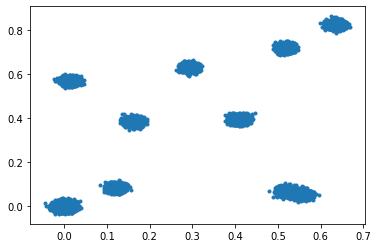

In [34]:
plt.plot(inputs[:, 0, 3], inputs[:, 0, 4], ".", label=f"input: {i + 1}")

In [13]:
torch.save(model.state_dict(), "./saved_models/3_0_two_task")

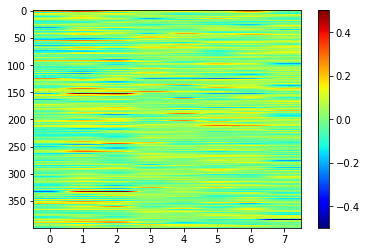

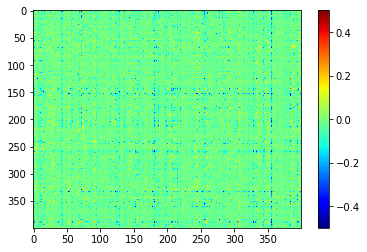

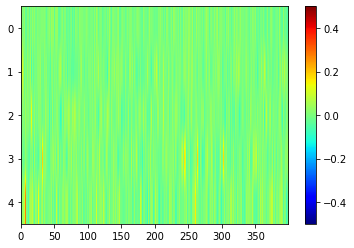

In [20]:
with torch.no_grad():
    weights_after_l = []
    for name, param in model.named_parameters():
        if param.requires_grad:
            weights_after_l.append((param).cpu().numpy())
            # print (name, param.data)

for i in range(len(weights_after_l) - 1):
    plt.imshow(
        weights_after_l[i] - weights_pre_l[i],
        aspect="auto",
        cmap="jet",
        vmin=-0.5,
        vmax=0.5,
    )
    plt.colorbar()
    plt.show()
    plt.close()

after


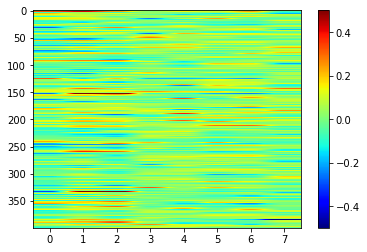

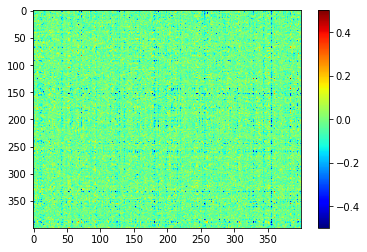

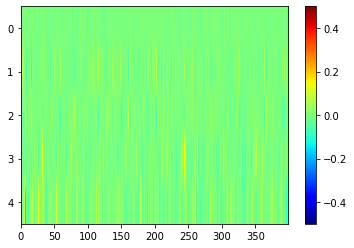

pre


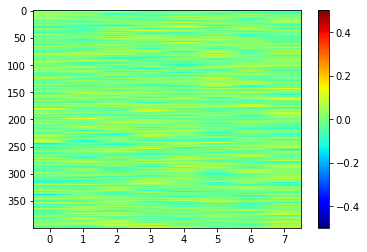

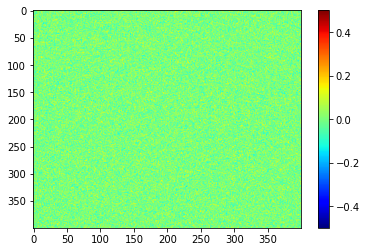

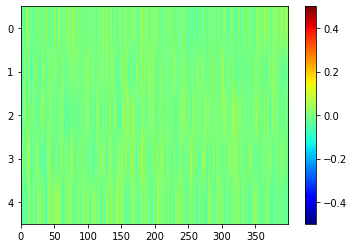

TypeError: Invalid shape (5,) for image data

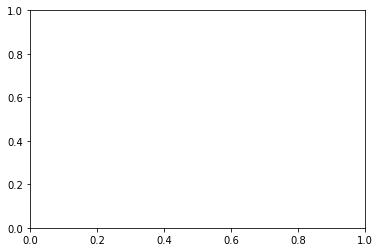

In [19]:
print("after")
for i in range(len(weights_after_l) - 1):
    plt.imshow(weights_after_l[i], aspect="auto", cmap="jet", vmin=-0.5, vmax=0.5)
    plt.colorbar()
    plt.show()
    plt.close()

print("pre")
for i in range(len(weights_after_l)):
    plt.imshow(weights_pre_l[i], aspect="auto", cmap="jet", vmin=-0.5, vmax=0.5)
    plt.colorbar()
    plt.show()
    plt.close()